# Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label,train=np.split(train,[1], axis=1)
train_label = train_label.ravel()

## приводим размерность к удобному для обаботки виду
as a Transformer class

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
class Resize(BaseEstimator, TransformerMixin):
    def __init__(self, size=28):
        self.size = size

    # fit() doesn't do anything, this is a transformer class
    def fit(self, X, y = None):
        return self

    #all the work is done here
    def transform(self, X):
        img = np.resize(X, (X.shape[0], self.size, self.size))
        return img

In [5]:
rs = Resize(size=28)
train_img = rs.transform(train)
test_img = rs.transform(test)

In [6]:
train.shape, train_img.shape, test.shape, test_img.shape

((42000, 784), (42000, 28, 28), (28000, 784), (28000, 28, 28))

In [7]:
# this is a reverse of Resize - back to vector
class Flatten(BaseEstimator, TransformerMixin):
    def __init__(self, size=28):
        self.size = size

    # fit() doesn't do anything, this is a transformer class
    def fit(self, X, y = None):
        return self

    #all the work is done here
    def transform(self, X):
        return X.reshape(X.shape[0],-1)

## Визуализируем исходные данные

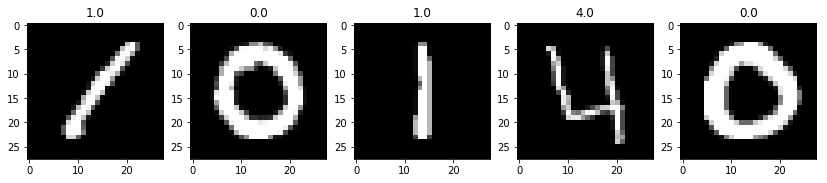

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Calculate angle and length of gradients using Sobel filter. Produce histo
as Transformer classes

In [9]:
class Gradient(BaseEstimator, TransformerMixin):
    def __init__(self, ksize=3):
        self.ksize = ksize

    # fit() doesn't do anything, this is a transformer class
    def fit(self, X, y = None):
        return self

    #all the work is done here
    def transform(self, X):
        #x,y of the gradient using Sobel filter
        sobel_x = np.zeros_like(X)
        sobel_y = np.zeros_like(X)
        for i in range(len(X)):
            sobel_x[i] = cv2.Sobel(X[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
            sobel_y[i] = cv2.Sobel(X[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
        
        #angle and length of a vector
        g, theta = cv2.cartToPolar(sobel_x, sobel_y)
        return g, theta

In [10]:
class GradientHisto(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins=16, normalize=True):
        self.n_bins=n_bins
        self.normalize = True

    # fit() doesn't do anything, this is a transformer class
    def fit(self, X, y = None):
        return self

    #all the work is done here
    def transform(self, X):
        #Gradients
        gr = Gradient()
        g, theta = gr.transform(X)
        
        #histo
        hist = np.zeros((len(X), self.n_bins))
        for i in range(len(X)):
            hist1, borders = np.histogram(
                theta[i],
                bins = self.n_bins,
                range = (0., 2. * np.pi),
                weights = g[i]
            )
            #print(hist.shape, hist[i].shape)
            hist[i] = hist1
            
        # По умолчанию используется L2 норма
        if self.normalize == True:
            hist = hist / np.linalg.norm(hist, axis=1)[:, None]
        
        return hist

In [11]:
gr = Gradient()
train_g, train_theta = gr.transform(train_img)

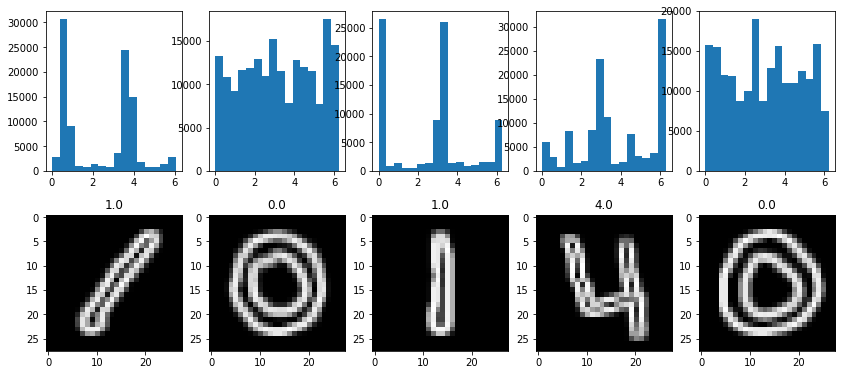

In [12]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Shift histo-max to zero ?


In [13]:
def ShiftHisto(train_hist):
    train_hist_shifted = np.zeros((len(train_img), 16))
    train_hist_argmax = np.argmax(train_hist, axis=1)

    for i in range(len(train_img)):
        train_hist[i] = np.roll(train_hist[i], -train_hist_argmax[i])
    return train_hist

## Binarization and Morphological filters

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
class Binarize(BaseEstimator, TransformerMixin):
    def __init__(self, threshold, max_value=255.0):
        self.threshold = threshold
        self.max_value = max_value

    # fit() doesn't do anything, this is a transformer class
    def fit(self, X, y = None):
        return self

    #all the work is done here
    def transform(self, X):
        return self.max_value * (X > self.threshold)

In [15]:
#TODO
# cv2.adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C)
# src - исходное одноканальное изображение
# maxValue - значение пикселей для которых интенсивность выше порога
# adaptiveMethod - метод оценки порога: cv2.ADAPTIVE_THRESH_MEAN_C,

In [16]:
class MorphFilter(BaseEstimator, TransformerMixin):
    filters = {
        #'erosion'=
    }
    def __init__(self, filt, k_size=2):
        self.filt = filt
        self.k_size = k_size
        self.kernel = np.ones((self.k_size, self.k_size), np.float32)

    # fit() doesn't do anything, this is a transformer class
    def fit(self, X, y = None):
        return self
    
    #all the work is done here
    def transform(self, X):
        ret = np.zeros_like(X)
        for i in range(len(X)):
            if self.filt == 'erode':
                ret[i] = cv2.erode(X[i],self.kernel,iterations = 1)
            elif self.filt == 'dilate':
                ret[i] = cv2.dilate(X[i],self.kernel,iterations = 1)
            elif self.filt == 'open':
                ret[i] = cv2.morphologyEx(X[i], cv2.MORPH_OPEN, self.kernel)
            elif self.filt == 'close':
                ret[i] = cv2.morphologyEx(X[i], cv2.MORPH_CLOSE, self.kernel)
        return ret

In [17]:
#Unit test
bn = Binarize(threshold=200)
t1 = bn.transform(train_img[0:3])

mf = MorphFilter(filt='erode', k_size=2)
t2 = mf.transform(t1)

fl = Flatten()
t3 = fl.transform(t2)

In [18]:
t3

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
#sharpen filter ?
#laplas? - edges ?
#bilateral ?
#distance transform on binary with edges ?

## Logistic Regression on the whole image

In [20]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train, test_size=0.2,
    random_state=42)

In [21]:
# Find optimal C and other params
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
lrcv = LogisticRegressionCV(n_jobs=-1, random_state=42, 
                          solver='saga', max_iter=100, 
                          multi_class='multinomial',class_weight='balanced',
                          Cs=np.logspace(-3,1,base=10,num=3),
                          penalty='l1',
                       )


In [22]:
lr = LogisticRegression(n_jobs=-1, random_state=42, 
                          solver='saga', max_iter=100, 
                          multi_class='multinomial',class_weight='balanced',
                          C=0.003,
                          penalty='l1',
                       )

In [23]:
#scaling doesn't work well here.
# from sklearn.preprocessing import StandardScaler
# lr_sc = StandardScaler()
# x_train = lr_sc.fit_transform(x_train)
# x_val = lr_sc.transform(x_val)

## Logit on binarized and morphed features

In [25]:
from sklearn.pipeline import Pipeline, FeatureUnion


In [26]:
#Logit on the binarized and morphed
rs = Resize(size=28)

lr_m = LogisticRegression(n_jobs=-1, solver='saga', random_state=42,
                                multi_class='multinomial',class_weight='balanced',
                                #Cs=np.logspace(-3,0,base=10,num=4)
                                C=0.001,
                                #cv=5,
                                penalty='l1',
                               )

lr_mp = Pipeline([
     ('rs', rs), #resize to square image size
     ('b', Binarize(threshold=200)),
     ('morph', FeatureUnion([
         ('er', MorphFilter(filt='erode',k_size=2)),
         ('di', MorphFilter(filt='dilate')),
         ('op', MorphFilter(filt='open')),
         ('cl', MorphFilter(filt='close')),
          ])),
     ('fl', fl), #(flatten) back to vector
    ('lr_morph', lr_m)
], memory="/tmp")

In [27]:
%%time
lr_mp.fit(x_train, y_train)

CPU times: user 11min 20s, sys: 542 ms, total: 11min 20s
Wall time: 11min 20s


/home/artem/miniconda3/envs/cv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory='/tmp',
     steps=[('rs', Resize(size=28)), ('b', Binarize(max_value=255.0, threshold=200)), ('morph', FeatureUnion(n_jobs=1,
       transformer_list=[('er', MorphFilter(filt='erode', k_size=2)), ('di', MorphFilter(filt='dilate', k_size=2)), ('op', MorphFilter(filt='open', k_size=2)), ('cl', MorphFilter(filt='c...'l1',
          random_state=42, solver='saga', tol=0.0001, verbose=0,
          warm_start=False))])

In [28]:
pred_val = lr_mp.predict(x_val)
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.9229761904761905


In [29]:

# 0.8920 C=0.0001, l1, multinomial, saga,
# 0.9194 C=0.001, l1, multinomial, saga,
# 0.9203 C=0.003
# 0.86xx C=0.003 scaled 0.86
# 0.9195 C=0.005
# 0.9187 C=0.007
# 0.9194 C=0.01, l1, multinomial, saga,
# 0.9173 C=0.05
# 0.9165 C=0.1, l1, multinomial, saga,

# On binarized only
# 0.89345 - bin default
# 0.897619 - bin, saga, multinomial, balanced
# 0.89773 bin, saga, multinomial, balanced, CV-0.001
# 0.8975 C=0.003 saga, multinomial, balanced, 
# 0.8964 CV-sag, l2, 5fold, multinomial, balanced,
# 0.9013 C=0.001 (L1) bin, saga , multinomial, balanced, 

#on binarized+morphed
# 0.90130# morph-close 0.90130 C=0.001 (L1) bin, saga , multinomial, balanced, 
# 0.92297 morph 4 C=0.001 (L1) bin, saga , multinomial, balanced, 

## Gradient Historgramms + models

In [30]:
%%time
# test of GradientHistoClass
gh_n_bins=32
gh = GradientHisto(gh_n_bins)
train_hist = gh.transform(train_img)

CPU times: user 3.91 s, sys: 204 ms, total: 4.11 s
Wall time: 3.17 s


In [31]:
from sklearn.decomposition import PCA
pca_h = PCA()
train_hist = pca_h.fit_transform(train_hist)

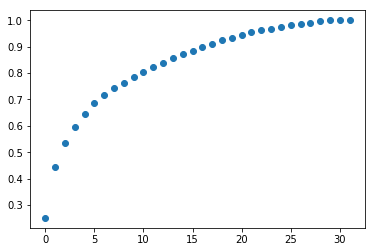

In [32]:
plt.plot(np.cumsum(pca_h.explained_variance_ratio_), 'o')

In [33]:
train_hist.shape

(42000, 32)

In [34]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

In [35]:
## Use NearestCentroid model

from sklearn.neighbors.nearest_centroid import NearestCentroid
nc = NearestCentroid()
nc.fit(x_train, y_train)
pred_val = nc.predict(x_val)
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.4369047619047619


In [36]:
## Logistic Regression

lr_h = LogisticRegression(solver='saga', C=10, penalty='l1', multi_class='multinomial')
lr_h.fit(x_train, y_train)
pred_val = lr_h.predict(x_val)
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.6086904761904762


/home/artem/miniconda3/envs/cv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## PCA on the whole image

In [37]:
from sklearn.decomposition import PCA

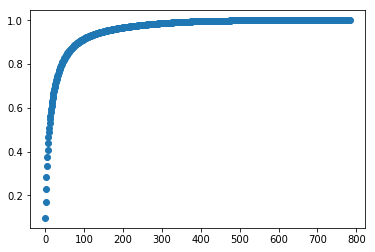

In [38]:
pca=PCA()
pca.fit(train, train_label)
#plot explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o')

In [39]:
#let's find the optimal number of components.
from sklearn.model_selection import GridSearchCV

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
pca_sc = StandardScaler()
pca = PCA()
svc = LinearSVC()
pca_pipe = Pipeline([
            ('sc', pca_sc ),
            ('pca', pca),
            ('svc', svc),
        ], memory="/tmp")

### Search optimal number of PCA components

In [41]:
np.logspace(5,9,base=2, num=10, dtype=np.uint16)

array([ 32,  43,  59,  80, 109, 149, 203, 276, 376, 512], dtype=uint16)

In [42]:
gcv_grid_params = {
    'pca__n_components': np.logspace(5,9,base=2, num=10, dtype=np.uint16)
}
gcv_params = {
    'scoring':'accuracy',
    'n_jobs': -1,
    'cv':5,
}
gcv = GridSearchCV(pca_pipe, gcv_grid_params, **gcv_params)

In [43]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train, test_size=0.2,
    random_state=42)

In [44]:
gcv.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory='/tmp',
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'pca__n_components': array([ 32,  43,  59,  80, 109, 149, 203, 276, 376, 512], dtype=uint16)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [45]:
gcv.best_params_
# {'pca__n_components': 203}

{'pca__n_components': 203}

In [46]:
pred_val = gcv.predict(x_val)
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.9046428571428572


# Pipeline / blending

## Ensemble trick with pipeline

Normally pipelines allow only one estmator class, and it should be the final one. If one wants to blend output of multiple models (metafeatures), Pipeline class can not be used as is.

This wrapper class allows us to produce metafeatures in the pipeline - predictions from different methods, and then fit a final estimator on these metrafeatures. This class pretends to be a transformer class, while under the hood it outputs predictions from a given model. 

You'd use it like this:
```
p = Pipiline([
   ('u', FeatureUnion([
     ('lr', ClassifierWrapper(LogisticRegression()) ),
     ('nc', ClassifierWrapper(NearestCentroid()) ),
   ])),
   ('xgb', XGBClassifier())
])
```
Here, predictions from Logistic Regressions  and NearestCentriod models become metafeatures for XGBClassifier.

In [47]:

from sklearn.metrics import get_scorer
class ClassifierWrapper(BaseEstimator, TransformerMixin):
    
    def __init__(
            self, estimator, verbose=None, 
            fit_params=None, 
            use_proba=True, #whether to use predict_proba in transform
            scoring=None, # calculate validation score, takes score function name
            ignore_one_class_proba=True, #return one less class probability, in case of use_proba.
            ):
        self.estimator = estimator
        self.verbose = verbose #True = 1, False = 0, 1 - moderately verbose, 2- extra verbose    
        if verbose is None:
            self.verbose=0
        else:
            self.verbose=verbose
        self.fit_params= fit_params
        self.use_proba = use_proba 
        self.scoring = scoring 
        #TODO check if scorer imported?
        self.score = None #variable to keep the score if scoring is set.
        self.use_proba_first_index = 0 #for slicing of class probabilities as returned by predict_proba()
        if ignore_one_class_proba == True:
            self.use_proba_first_index = 1 #will return only probabilityed for classes 1:N, ignore class 0

    def fit(self,X,y):
        fp=self.fit_params
        if self.verbose==2: print("X: ", X.shape, "\nFit params:", self.fit_params)
        
        if fp is not None:
            self.estimator.fit(X,y, **fp)
        else:
            self.estimator.fit(X,y)
        
        return self
    
    def transform(self, X):
        if self.use_proba:
            return self.estimator.predict_proba(X)[:, self.use_proba_first_index:]
        else:
            return self.estimator.predict(X).reshape(-1, 1)
    
    def fit_transform(self,X,y,**kwargs):
        self.fit(X,y)
        p = self.transform(X)
        if self.scoring is not None:
            self.score = eval(self.scoring+"(y,p)")
            #TODO print own instance name?
            if self.verbose >0: print("score: ", self.score) 
        return p
    
    def predict(self,X):
        return self.estimator.predict(X)
    
    def predict_proba(self,X):
        return self.estimator.predict_proba(X)

### Logit on the raw image data step

In [48]:
lr_cw = ClassifierWrapper(lr)

### Logit on the binarised+morphed image data step

In [49]:
lr_mp_cw = ClassifierWrapper(lr_mp)

### PCA on the raw image data step

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
pca_sc = StandardScaler()
pca = PCA(n_components=203)
svc = LinearSVC()
pca_pipe = Pipeline([
            ('sc', pca_sc ),
            ('pca', pca),
            ('svc', svc),
        ], memory="/tmp")
pca_cw = ClassifierWrapper(pca_pipe, use_proba=False)

In [51]:
#pca_pipe.fit(train, train_label)

### Gistogramm + Nearest Centroid step

In [52]:
gh_pipe= Pipeline([
    ('rs', rs), #resize from vector to square matrix
    ('gh', gh),
    ('gh_pca', PCA()), 
    ('nc', nc),
], memory="/tmp")
gh_cw = ClassifierWrapper(gh_pipe, use_proba=False)

### Gistogramm + Logit step

In [53]:
gh_lr_pipe= Pipeline([
    ('rs', rs), #resize from vector to square matrix
    ('gh', gh),
    ('gh_pca', PCA()), 
    ('gh_lr', lr_h),
], memory="/tmp")
gh_lr_cw = ClassifierWrapper(gh_lr_pipe, use_proba=False)

### This is a final estimator on the meta features

In [54]:
from xgboost import XGBClassifier

xgb_params={
    'objective': 'multi:softmax', #softprob
    'num_class':10,
    'eta': 0.1,
    'max_depth': 5,
    'silent' :1,
    'eval_metric' : "merror",
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.3,
    'seed':17,
    'num_rounds':5000,
}

xgb = XGBClassifier(**xgb_params)

### Pipe definition

In [55]:
pipe3 = Pipeline([
    ('u1', FeatureUnion([
        ('lr_cw', lr_cw),
        ('lr_mp_cw', lr_mp_cw),
        ('pca_cw', pca_cw),
        ('gh_cw', gh_cw),
        ('gh_lr_cw', gh_lr_cw),
    ])),
    #('lrfinal', LogisticRegression()),
    ('xgb', xgb),
],memory="/tmp")


In [56]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train, test_size=0.2,
    random_state=42)

In [57]:
y_train.shape, x_train.shape

((33600,), (33600, 784))

In [58]:
pipe3.fit(x_train, y_train)

/home/artem/miniconda3/envs/cv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/artem/miniconda3/envs/cv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/artem/miniconda3/envs/cv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory='/tmp',
     steps=[('u1', FeatureUnion(n_jobs=1,
       transformer_list=[('lr_cw', ClassifierWrapper(estimator=LogisticRegression(C=0.003, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l1',
        ...m_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=17, silent=1, subsample=0.8))])

In [59]:
pred_val = pipe3.predict(x_val)

/home/artem/miniconda3/envs/cv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [60]:
pred_val

array([8., 1., 9., ..., 3., 0., 9.])

## Оцениваем качество решение на валидационной выборке

In [61]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.9432142857142857


In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.97      0.97      0.97       816
        1.0       0.98      0.98      0.98       909
        2.0       0.94      0.93      0.93       846
        3.0       0.93      0.92      0.93       937
        4.0       0.94      0.95      0.94       839
        5.0       0.90      0.91      0.90       702
        6.0       0.95      0.97      0.96       785
        7.0       0.95      0.95      0.95       893
        8.0       0.93      0.93      0.93       835
        9.0       0.93      0.92      0.93       838

avg / total       0.94      0.94      0.94      8400



In [63]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[794   0   1   0   2   8   8   0   2   1]
 [  0 893   5   0   1   2   1   3   2   2]
 [  4   3 788   7   9   8   8   6  12   1]
 [  1   1  11 863   0  27   2   7  16   9]
 [  2   1   5   1 794   1   8   4   1  22]
 [  5   2   8  21   3 640   8   1  10   4]
 [  6   1   5   1   2   4 760   1   5   0]
 [  0   1   7   6  10   3   0 846   3  17]
 [  2   2   8  15   7  17   4   4 773   3]
 [  5   3   2  10  16   3   0  22   5 772]]


## Предсказания на тестовых данных

In [64]:
pred_test = pipe3.predict(test)

/home/artem/miniconda3/envs/cv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Визуализируем предсказания

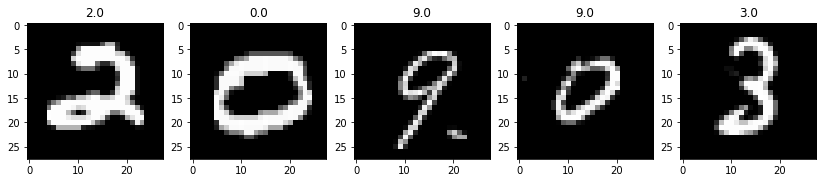

In [65]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [66]:
with open('mnist2.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [67]:
!head mnist1.csv

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0


In [68]:
!pwd

/home/artem/hse-cv/lectures/cv/002


In [69]:
#  submission scored 0.94028

## Train on the whole set

In [70]:
pipe3.fit(train, train_label)

/home/artem/miniconda3/envs/cv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/artem/miniconda3/envs/cv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/artem/miniconda3/envs/cv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory='/tmp',
     steps=[('u1', FeatureUnion(n_jobs=1,
       transformer_list=[('lr_cw', ClassifierWrapper(estimator=LogisticRegression(C=0.003, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l1',
        ...m_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=17, silent=1, subsample=0.8))])

In [72]:
pred_test = pipe3.predict(test)

/home/artem/miniconda3/envs/cv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [73]:
with open('mnist2a.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [75]:
#submission scored 0,94314